<a href="https://colab.research.google.com/github/Ohsoo46/AIFFEL_QUEST/blob/main/ds6_%EC%98%A4%EB%AA%85%EC%88%98_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신용카드 사기 탐지 분류 문제

이 노트북의 다음 라이브러리 버전은 "파이썬 머신러닝 완벽 가이드 개정2판"을 기준으로 설정되었습니다.

### 라이브러리 버전
2. `xgboost` : 1.5.0
3. `lightgbm` : 3.3.2

### 기타 사용 라이브러리
1. `hyperopt`

In [ ]:
!pip uninstall -y xgboost lightgbm

Found existing installation: xgboost 3.1.1
Uninstalling xgboost-3.1.1:
  Successfully uninstalled xgboost-3.1.1
Found existing installation: lightgbm 3.3.2
Uninstalling lightgbm-3.3.2:
  Successfully uninstalled lightgbm-3.3.2


In [ ]:
!pip install xgboost==1.5.0 lightgbm==3.3.2

  Using cached xgboost-1.5.0-py3-none-manylinux2014_x86_64.whl.metadata (1.7 kB)
  Using cached lightgbm-3.3.2-py3-none-manylinux1_x86_64.whl.metadata (15 kB)
Using cached xgboost-1.5.0-py3-none-manylinux2014_x86_64.whl (173.5 MB)
Using cached lightgbm-3.3.2-py3-none-manylinux1_x86_64.whl (2.0 MB)


In [ ]:
!pip install hyperopt

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 훈련 데이터와 테스트 데이터는 미리 준비되어 있습니다.

train_df = pd.read_csv('/content/drive/MyDrive/ds6_Quest/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ds6_Quest/test.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터셋 정보

2013년 9월 유럽 신용카드 사용자들의 거래 내역을 포함하고 있습니다.
이 데이터셋은 이틀 간의 거래 내역으로 데이터셋은 크게 불균형하며, 사기 거래(양성 클래스)는 전체 거래의 약 0.17%에 불과합니다.

이 데이터셋은 PCA 변환을 거친 수치형 변수들만 포함하고 있습니다. 안타깝게도 기밀 유지 문제로 인해 원본 특징과 데이터에 대한 자세한 배경 정보는 제공할 수 없습니다. V1, V2, …, V28은 PCA로 얻은 주성분이며, PCA 변환을 거치지 않은 유일한 특징은 'Time'과 'Amount'입니다. 'Time'은 각 거래와 데이터셋의 첫 거래 사이의 경과 시간(초)을 나타내며, 'Amount'는 거래 금액입니다. 'Amount' 특징은 예시 의존적 비용 민감 학습 등에 사용될 수 있습니다. 'Class'는 응답 변수로, 사기 거래인 경우 1, 그렇지 않은 경우 0의 값을 가집니다.

클래스 불균형 비율을 고려하여, 정밀도-재현율 곡선 아래 영역(AUPRC)을 사용하여 정확도를 측정할 것을 권장합니다. 불균형 분류에서는 혼동 행렬 정확도가 큰 의미가 없습니다.

이 데이터셋은 Worldline과 ULB(브뤼셀 자유 대학교) 머신러닝 그룹(http://mlg.ulb.ac.be) 간의 빅데이터 마이닝 및 사기 탐지 관련 연구 협력을 통해 수집 및 분석되었습니다.
관련 주제에 대한 현재 및 과거 프로젝트에 대한 자세한 내용은 https://www.researchgate.net/project/Fraud-detection-5 및 DefeatFraud 프로젝트 페이지에서 확인할 수 있습니다.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 21  V20     17

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113923 entries, 0 to 113922
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      113923 non-null  int64  
 1   Time    113923 non-null  float64
 2   V1      113923 non-null  float64
 3   V2      113923 non-null  float64
 4   V3      113923 non-null  float64
 5   V4      113923 non-null  float64
 6   V5      113923 non-null  float64
 7   V6      113923 non-null  float64
 8   V7      113923 non-null  float64
 9   V8      113923 non-null  float64
 10  V9      113923 non-null  float64
 11  V10     113923 non-null  float64
 12  V11     113923 non-null  float64
 13  V12     113923 non-null  float64
 14  V13     113923 non-null  float64
 15  V14     113923 non-null  float64
 16  V15     113923 non-null  float64
 17  V16     113923 non-null  float64
 18  V17     113923 non-null  float64
 19  V18     113923 non-null  float64
 20  V19     113923 non-null  float64
 21  V20     11

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
test_df.describe()


,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,...,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000
mean,227844.000000,145396.169808,0.254759,-0.061154,-0.739555,-0.176137,0.264150,-0.087346,0.120988,-0.048337,...,-0.046430,0.042428,0.125609,0.033672,-0.013512,-0.138398,-0.018897,-0.003140,-0.003667,89.867850
std,32886.881696,14553.200321,2.084808,1.708359,1.402141,1.461789,1.399511,1.381543,1.269186,1.140927,...,0.831851,0.718441,0.788888,0.678614,0.615591,0.567769,0.468657,0.420530,0.361528,256.236008
min,170883.000000,120396.000000,-46.855047,-50.383269,-48.325589,-5.683171,-113.743307,-20.869626,-23.386192,-39.688571,...,-54.497720,-21.620120,-7.417140,-36.666000,-2.790479,-8.696627,-1.855355,-9.895244,-15.430084,0.000000
25%,199363.500000,132928.500000,-0.803531,-0.691506,-1.598860,-0.978315,-0.437285,-0.880171,-0.491675,-0.273015,...,-0.247537,-0.223898,-0.534543,-0.142571,-0.382480,-0.450968,-0.313872,-0.075609,-0.062317,5.950000
50%,227844.000000,145247.000000,0.117889,-0.005846,-0.734520,-0.337083,0.250458,-0.389808,0.153525,-0.035902,...,-0.104920,0.036139,0.186973,0.040791,0.016358,-0.193153,-0.041566,-0.009555,-0.028507,22.450000
75%,256324.500000,157639.500000,1.978707,0.803286,0.121444,0.431529,0.882923,0.309498,0.746755,0.285891,...,0.091959,0.253758,0.750595,0.227957,0.524460,0.221885,0.214766,0.093824,0.078238,78.000000
max,284805.000000,172788.000000,2.454930,12.730564,3.937048,15.304184,29.162172,73.301626,120.589494,12.766112,...,23.643417,20.063786,8.272233,22.528412,4.584549,6.070850,3.415636,31.612198,16.129609,25691.160000


In [ ]:
train_df.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,...,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,85441.000000,61091.567090,-0.169838,0.040771,0.493037,0.117429,-0.176102,0.058235,-0.080669,0.032227,...,-0.028287,-0.083744,-0.022450,0.009008,0.092269,0.012603,0.002093,0.002445,87.336704,0.002107
std,49329.817362,27828.109419,1.850529,1.610874,1.383241,1.371910,1.338609,1.295123,1.208518,1.227630,...,0.743713,0.667318,0.584508,0.598760,0.465505,0.490660,0.391951,0.307315,245.954429,0.045851
min,0.000000,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-43.557242,-73.216718,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,42720.500000,41216.500000,-0.986667,-0.539174,-0.064747,-0.743475,-0.828769,-0.691129,-0.586314,-0.162638,...,-0.230722,-0.546777,-0.170294,-0.332459,-0.195933,-0.330346,-0.065125,-0.027054,5.480000,0.000000
50%,85441.000000,60776.000000,-0.183560,0.109679,0.623352,0.124307,-0.226228,-0.202634,-0.031932,0.056664,...,-0.054462,-0.066786,-0.036211,0.059474,0.135662,-0.058966,0.008693,0.021152,21.890000,0.000000
75%,128161.500000,78622.000000,1.184446,0.804221,1.297352,0.937632,0.374445,0.449200,0.462616,0.350995,...,0.128337,0.363165,0.098707,0.415860,0.399458,0.272938,0.089727,0.078302,76.720000,0.000000
max,170882.000000,120396.000000,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


In [ ]:
train_df["id"].max(), test_df["id"].min()

(170882, 170883)

# 뼈대 만들기

머신러닝 파이프라인은

데이터 준비 → 모델 정의 → 학습 → 예측 → 평가의 형태를 띕니다.

최소한의 형태로 파이프라인만 구성해 보겠습니다.

In [ ]:
# Time 컬럼을 삭제(drop), axis=1 : 열(column) 삭제, inplace=True : 새 변수로 만들지 않고 train_copy 자체에서 바로 제거
train_copy = train_df.copy()
train_copy.drop('Time', axis=1, inplace=True)

In [ ]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   V1      170883 non-null  float64
 2   V2      170883 non-null  float64
 3   V3      170883 non-null  float64
 4   V4      170883 non-null  float64
 5   V5      170883 non-null  float64
 6   V6      170883 non-null  float64
 7   V7      170883 non-null  float64
 8   V8      170883 non-null  float64
 9   V9      170883 non-null  float64
 10  V10     170883 non-null  float64
 11  V11     170883 non-null  float64
 12  V12     170883 non-null  float64
 13  V13     170883 non-null  float64
 14  V14     170883 non-null  float64
 15  V15     170883 non-null  float64
 16  V16     170883 non-null  float64
 17  V17     170883 non-null  float64
 18  V18     170883 non-null  float64
 19  V19     170883 non-null  float64
 20  V20     170883 non-null  float64
 21  V21     17

In [ ]:
# iloc: 행, 열을 인덱스 위치 기준으로 선택하는 함수
# [:, :-1] 은 → 모든 행(:), 그리고 마지막 열을 제외한 모든 열(-1)
# train_copy에서 마지막 열(Class)을 제외한 입력 특성(feature) 들만 X_features에 저장
# x_features = V1~ V28, AMount 값 같은 입력값만
X_features = train_copy.iloc[:, :-1]
y_target = train_copy.iloc[:, -1]

### 전체 데이터셋을 “훈련용(Train)”과 검증용(Validation)”으로 분리

In [ ]:
from sklearn.model_selection import train_test_split  #  sklearn  패키지 안의  model_selection모듈에서 데이터를 훈련/검증 세트로 나눔

X_train, X_val, y_train, y_val = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)
# 입력(X_features)과 정답(레이블, y_target)을 동시에
# X와 같은 순서로 섞이면서 동일하게 분리
# 입력과 정답이 서로 짝이 맞게 섞이는 오류를 방지

In [ ]:
# 크기 확인
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train distribution:\n", y_train.value_counts(normalize = True))
print("y_val distribution:\n", y_val.value_counts(normalize=True))

X_train shape: (136706, 30)
X_val shape: (34177, 30)
y_train distribution:
 Class
0    0.997893
1    0.002107
Name: proportion, dtype: float64
y_val distribution:
 Class
0    0.997893
1    0.002107
Name: proportion, dtype: float64


크기 확인 결과
- 사기 거래는 전체의 0.210 % : 극도로 불균형한 데이터셋
→ 사기 거래는 약 1,000건 중 2건(0.2%)

이렇게 되면 모델이 단순히 “전부 0(정상)”이라고만 예측해도
**정확도(Accuracy)는 99.8%*

하지만, 진짜 사기 거래를 놓치게 되므로
정확도 대신 F1-score 를 사용 권장
(F1-score는 Precision과 Recall의 균형을 봄)

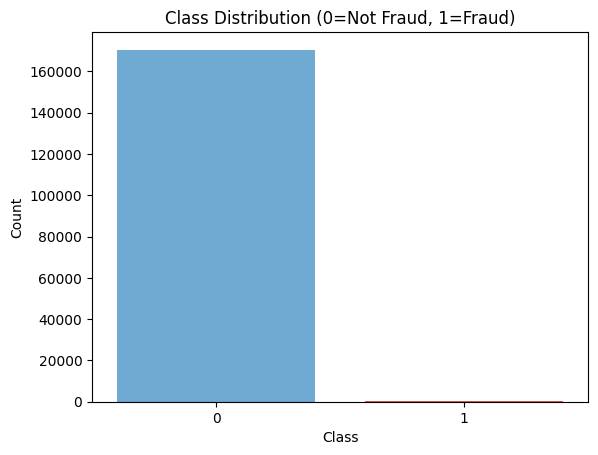

In [ ]:
sns.countplot(x='Class', data=train_df, palette=['#5DADE2', '#E74C3C'])
plt.title('Class Distribution (0=Not Fraud, 1=Fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

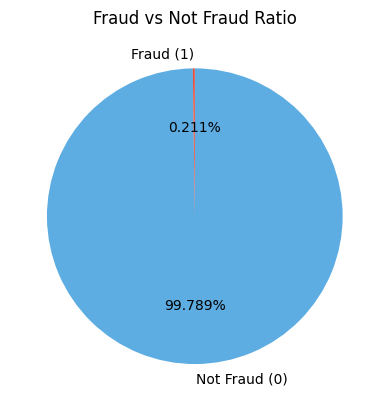

In [ ]:
# 비율 파이차트(pie chart)
fraud_counts = train_df['Class'].value_counts()
labels = ['Not Fraud (0)', 'Fraud (1)']
colors = ['#5DADE2','#E74C3C']

plt.pie(fraud_counts, labels=labels, autopct='%1.3f%%', colors=colors, startangle=90, counterclock=False)
plt.title('Fraud vs Not Fraud Ratio')
plt.show()

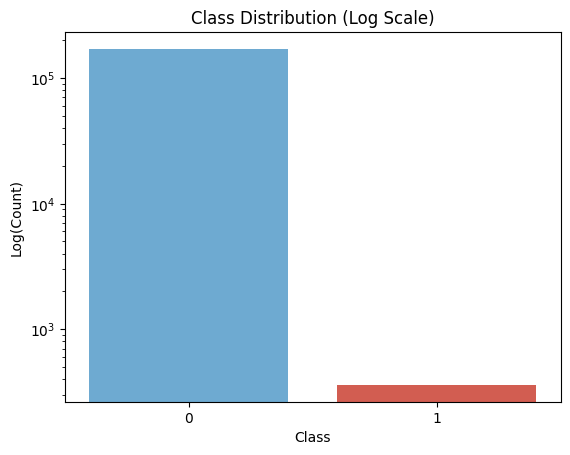

In [ ]:
# 로그 스케일 막대그래프 (Log-scaled Bar)
sns.countplot(x='Class', data=train_df, palette=['#5DADE2','#E74C3C'])
plt.yscale('log')
plt.title('Class Distribution (Log Scale)')
plt.xlabel('Class')
plt.ylabel('Log(Count)')
plt.show()

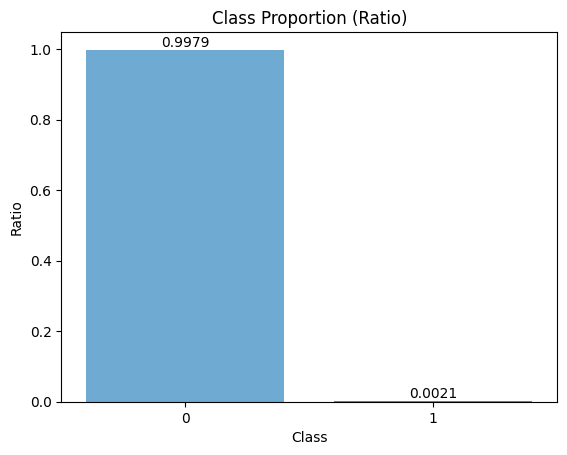

In [ ]:
# Class 비율 막대그래프 (비율로 표현)
fraud_ratio = train_df['Class'].value_counts(normalize=True).reset_index()
fraud_ratio.columns = ['Class', 'Ratio']

sns.barplot(x='Class', y='Ratio', data=fraud_ratio, palette=['#5DADE2','#E74C3C'])
plt.title('Class Proportion (Ratio)')
plt.ylabel('Ratio')
plt.xlabel('Class')
for i, val in enumerate(fraud_ratio['Ratio']):
    plt.text(i, val + 0.0001, f'{val:.4f}', ha='center', va='bottom')
plt.show()


In [ ]:
# 데이터 비율 요약 테이블
class_summary = pd.DataFrame({
    'Count': train_df['Class'].value_counts(),
    'Ratio (%)': train_df['Class'].value_counts(normalize=True) * 100
})
display(class_summary)


,Count,Ratio (%)
Class,,
0,170523,99.78933
1,360,0.21067


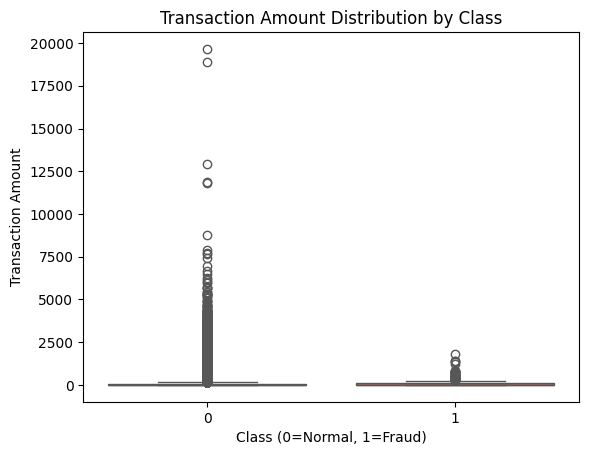

In [ ]:
#  분포 비교 시각화 (Amount vs Class)

# 사기 거래가 특정 금액대에서 발생하는지 확인 가능
# 불균형뿐 아니라 특성 차이 탐색(EDA) 용도
sns.boxplot(x='Class', y='Amount', data=train_df, palette=['#5DADE2','#E74C3C'])
plt.title('Transaction Amount Distribution by Class')
plt.xlabel('Class (0=Normal, 1=Fraud)')
plt.ylabel('Transaction Amount')
plt.show()


결과 해석
class = 0(정상거래); 금액이 전반적으로 넓게 분포, 일부 거래는 10,000~20,000 까지 분포.
class = 0(사기거래): 대부분 소액(2500이하)에서 발생한다고 볼 수 있음
- 예외: Boxplot(Amount vs Class)그래프는 데이터의 밀집 정도와 이상치 위치만 보여줌. 빈도(거래 횟수)를 직접 나타나지 않음
제안--> 히스토그램을 추가 확인

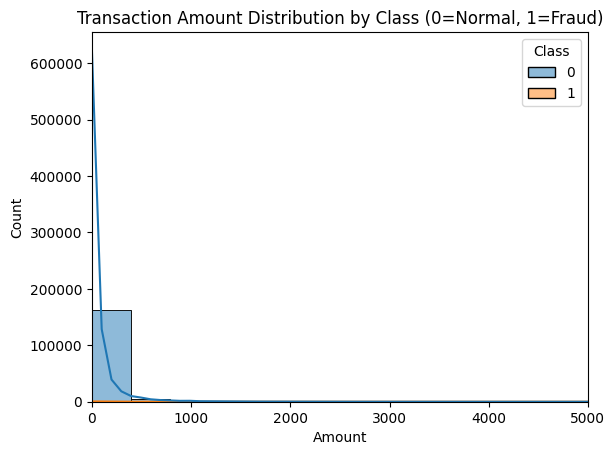

In [ ]:
# 사기 vs 정상의 금액 분포를 밀도 기반으로 비교
# 금액대별 히스토그램 시행
sns.histplot(data=train_df, x='Amount', hue='Class', bins=50, kde=True)
plt.xlim(0, 5000)
plt.title('Transaction Amount Distribution by Class (0=Normal, 1=Fraud)')
plt.show()


In [ ]:
print('학습 데이터 간 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100) # y_train 안에 들어 있는 값(0과 1)의 개수를 세는 명령어, --> 구한 비율을 백분율(%) 로
print('검증 데이터 간 레이블 값 비율')
print(y_val.value_counts()/y_val.shape[0] * 100)

학습 데이터 간 레이블 값 비율
Class
0    99.789329
1     0.210671
Name: count, dtype: float64
검증 데이터 간 레이블 값 비율
Class
0    99.789332
1     0.210668
Name: count, dtype: float64


결과 해석
- y_train : class 0 / 99.79% 정상, class 1/ 0.21% (사기), 정상거래가 대부분
- y_yal : 99.79%  class 1(사기), 0.21%, 분리후에도 비율 유지됨

stratify=y_target 옵션이 잘 적용되어
Train / Validation 모두 Class 비율이 완전히 동일하게 유지되었음

In [ ]:
from sklearn.linear_model import LogisticRegression

# 학습
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)

# 검증
lr_val = lr_clf.predict(X_val)
lr_val_proba = lr_clf.predict_proba(X_val)[:,1]

print('학습 완료!')

학습 완료!


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

lr_val_confusion = confusion_matrix(y_val, lr_val)
lr_val_accuracy = accuracy_score(y_val, lr_val)
lr_val_precision = precision_score(y_val, lr_val)
lr_val_recall = recall_score(y_val, lr_val)
lr_val_f1 = f1_score(y_val, lr_val)

lr_val_roc_score = roc_auc_score(y_val, lr_val_proba)
print(lr_val_roc_score)

print("검증 데이터 혼동행렬:")
print(lr_val_confusion)
print("검증 데이터 정확도: ",lr_val_accuracy)
print("검증 데이터 정밀도: ",lr_val_precision)
print("검증 데이터 재현율: ",lr_val_recall)
print("검증 데이터 F1 점수: ",lr_val_f1)
print("검증 데이터 AUC: ",lr_val_roc_score)


0.9633741386893417
검증 데이터 혼동행렬:
[[34092    13]
 [   29    43]]
검증 데이터 정확도:  0.9987711033736139
검증 데이터 정밀도:  0.7678571428571429
검증 데이터 재현율:  0.5972222222222222
검증 데이터 F1 점수:  0.671875
검증 데이터 AUC:  0.9633741386893417


In [ ]:

X_test_features = test_df[lr_clf.feature_names_in_]

# 예측

y_pred = lr_clf.predict(X_test_features)
y_pred_proba = lr_clf.predict_proba(X_test_features)[:, 1]

In [ ]:
# 3. 제출용 DataFrame 생성

submission = pd.DataFrame({
    'id': test_df['id'],      # test_df에 반드시 id가 포함되어야 함
    'Class': y_pred
})

In [ ]:

# 저장
submission.to_csv('./submission.csv', index=False)
print(" submission.csv 파일 생성 완료!")

 submission.csv 파일 생성 완료!


In [ ]:
from google.colab import files
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, precision_recall_curve
)


In [ ]:
# =============== 0) 불균형 가중치 ===============
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale_pos_weight = neg / max(1, pos)



In [ ]:
# =============== 1) 모델 정의/학습 ===============
lgbm = LGBMClassifier(
    n_estimators=3000,
    learning_rate=0.02,
    num_leaves=64,
    max_depth=-1,
    min_child_samples=50,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    is_unbalance=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
)
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(150, verbose=False)]
)
print("LightGBM 학습 완료!", lgbm.best_iteration_)



LightGBM 학습 완료! 1


In [ ]:
# =============== 2) 검증 확률/기본 평가 ===============
val_proba = lgbm.predict_proba(X_val, num_iteration=lgbm.best_iteration_)[:, 1]
auc_val = roc_auc_score(y_val, val_proba)

def eval_at_thr(y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    cm   = confusion_matrix(y_true, pred)
    acc  = accuracy_score(y_true, pred)
    pre  = precision_score(y_true, pred, zero_division=0)
    rec  = recall_score(y_true, pred)
    f1   = f1_score(y_true, pred)
    return cm, acc, pre, rec, f1

cm05, acc05, pre05, rec05, f105 = eval_at_thr(y_val, val_proba, 0.50)
print("\n[thr=0.50] 혼동행렬:\n", cm05)
print(f"Accuracy={acc05:.6f}  Precision={pre05:.6f}  Recall={rec05:.6f}  F1={f105:.6f}  AUC={auc_val:.6f}")




[thr=0.50] 혼동행렬:
 [[33221   884]
 [    8    64]]
Accuracy=0.973901  Precision=0.067511  Recall=0.888889  F1=0.125490  AUC=0.948781


In [ ]:
# =============== 3) F1 최대 임계값 자동 탐색 ===============
prec, rec, thr = precision_recall_curve(y_val, val_proba)
# thr 길이는 prec/rec보다 1 작음 → 마지막 요소 제외하고 F1 계산
f1s = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = np.argmax(f1s)
best_thr = float(thr[best_idx])
best_f1_est = float(f1s[best_idx])
print(f"\n탐색된 best threshold = {best_thr:.4f} (추정 F1={best_f1_est:.4f})")




탐색된 best threshold = 0.9607 (추정 F1=0.2664)


In [ ]:
# =============== 4) best threshold로 재평가 ===============
cmb, accb, preb, recb, f1b = eval_at_thr(y_val, val_proba, best_thr)
print(f"\n[best_thr={best_thr:.3f}] 혼동행렬:\n", cmb)
print(f"Accuracy={accb:.6f}  Precision={preb:.6f}  Recall={recb:.6f}  F1={f1b:.6f}  AUC={auc_val:.6f}")




[best_thr=0.961] 혼동행렬:
 [[33780   325]
 [   11    61]]
Accuracy=0.990169  Precision=0.158031  Recall=0.847222  F1=0.266376  AUC=0.948781


In [ ]:
# =============== 5) (선택) 제출 저장 ===============
# 훈련과 동일한 피처 사용 보장
feature_cols = X_train.columns
X_test_features = test_df[feature_cols]

test_proba = lgbm.predict_proba(X_test_features, num_iteration=lgbm.best_iteration_)[:, 1]
test_pred  = (test_proba >= best_thr).astype(int)

submission = pd.DataFrame({"id": test_df["id"], "Class": test_pred})
submission.to_csv("./submission_lgb_bestthr.csv", index=False)
print("\n submission_lgb_bestthr.csv 저장 완료!")


 submission_lgb_bestthr.csv 저장 완료!


In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, precision_recall_curve)


In [ ]:
# 0-1) 피처/라벨 분리 (Time, Class 제외)
drop_cols = ['Time', 'Class']
feature_cols = [c for c in train_df.columns if c not in drop_cols]
X = train_df[feature_cols].copy()
y = train_df['Class'].copy()


In [ ]:
# 0-2) 학습/검증 분할 (계층화)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



In [ ]:
# 0-3) 평가 함수 + F1 최적 임계값 탐색
def evaluate(y_true, proba, thr=0.5, title=""):
    pred = (proba >= thr).astype(int)
    cm   = confusion_matrix(y_true, pred)
    acc  = accuracy_score(y_true, pred)
    pre  = precision_score(y_true, pred, zero_division=0)
    rec  = recall_score(y_true, pred)
    f1   = f1_score(y_true, pred)
    auc  = roc_auc_score(y_true, proba)
    print(f"\n[{title} @thr={thr:.3f}]")
    print("혼동행렬:\n", cm)
    print(f"Accuracy={acc:.6f}  Precision={pre:.6f}  Recall={rec:.6f}  F1={f1:.6f}  ROC-AUC={auc:.6f}")
    return {"thr":thr,"acc":acc,"pre":pre,"rec":rec,"f1":f1,"auc":auc}

def best_threshold_by_f1(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1s = 2*(prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    i = np.argmax(f1s)
    return float(thr[i]), float(f1s[i]), float(prec[i]), float(rec[i])


In [ ]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
scale_pos_weight = neg/max(1,pos)

lr_bal = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
lgb_bal = LGBMClassifier(
    n_estimators=2000, learning_rate=0.02, num_leaves=64,
    subsample=0.9, colsample_bytree=0.9, min_child_samples=50,
    scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1
)

lr_bal.fit(X_train, y_train)
lgb_bal.fit(X_train, y_train)

lr_proba  = lr_bal.predict_proba(X_val)[:,1]
lgb_proba = lgb_bal.predict_proba(X_val)[:,1]

thr_lr, *_ = best_threshold_by_f1(y_val, lr_proba)
thr_lgb,*_ = best_threshold_by_f1(y_val, lgb_proba)

evaluate(y_val, lr_proba, thr_lr, "LR(class_weight)")
evaluate(y_val, lgb_proba, thr_lgb, "LGBM(scale_pos_weight)")



[LR(class_weight) @thr=1.000]
혼동행렬:
 [[34093    12]
 [   14    58]]
Accuracy=0.999239  Precision=0.828571  Recall=0.805556  F1=0.816901  ROC-AUC=0.980153

[LGBM(scale_pos_weight) @thr=0.812]
혼동행렬:
 [[34105     0]
 [    9    63]]
Accuracy=0.999737  Precision=1.000000  Recall=0.875000  F1=0.933333  ROC-AUC=0.945138


{'thr': 0.8117243754531687,
 'acc': 0.9997366650086316,
 'pre': 1.0,
 'rec': 0.875,
 'f1': 0.9333333333333333,
 'auc': np.float64(0.9451379726009546)}

SMOTE(오버샘플링) – 파이프라인으로 누수 방지

※ SMOTE는 학습 세트에만 적용함

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=5)

lgb_smote = Pipeline(steps=[
    ("smote", smote),
    ("lgbm", LGBMClassifier(
        n_estimators=1500, learning_rate=0.03, num_leaves=48,
        subsample=0.9, colsample_bytree=0.9, min_child_samples=40,
        random_state=42, n_jobs=-1
    ))
])


In [ ]:
lgb_smote.fit(X_train, y_train)
proba_smote = lgb_smote.predict_proba(X_val)[:,1]
thr_smote,*_ = best_threshold_by_f1(y_val, proba_smote)
evaluate(y_val, proba_smote, thr_smote, "LGBM+SMOTE")



[LGBM+SMOTE @thr=0.999]
혼동행렬:
 [[34103     2]
 [    9    63]]
Accuracy=0.999678  Precision=0.969231  Recall=0.875000  F1=0.919708  ROC-AUC=0.977432


{'thr': 0.9992430209453832,
 'acc': 0.9996781461216607,
 'pre': 0.9692307692307692,
 'rec': 0.875,
 'f1': 0.9197080291970803,
 'auc': np.float64(0.9774324390363095)}

# 3 모델 앙상블로 성능 비교


2-1) 개별 모델(XGB, LGBM, LR) 학습

In [ ]:
pip install -U xgboost

  Using cached xgboost-3.1.1-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.1-py3-none-manylinux_2_28_x86_64.whl (115.9 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.5.0
    Uninstalling xgboost-1.5.0:
      Successfully uninstalled xgboost-1.5.0


In [ ]:

from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=3000, learning_rate=0.02, max_depth=6,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight, tree_method="hist",
    random_state=42, n_jobs=-1, eval_metric="auc"
)
xgb.fit(X_train, y_train)

xgb_proba = xgb.predict_proba(X_val)[:,1]
thr_xgb,*_ = best_threshold_by_f1(y_val, xgb_proba)
evaluate(y_val, xgb_proba, thr_xgb, "XGB(scale_pos_weight)")



[XGB(scale_pos_weight) @thr=0.971]
혼동행렬:
 [[34105     0]
 [   10    62]]
Accuracy=0.999707  Precision=1.000000  Recall=0.861111  F1=0.925373  ROC-AUC=0.975425


{'thr': 0.9707126021385193,
 'acc': 0.9997074055651461,
 'pre': 1.0,
 'rec': 0.8611111111111112,
 'f1': 0.9253731343283582,
 'auc': np.float64(0.9754247503624428)}

2-2) 소프트 보팅 앙상블 (확률 평균)

In [ ]:
# 간단한 가중 평균: LGBM 0.5, XGB 0.4, LR 0.1 (가중치는 조정 가능)
ens_proba = 0.5*lgb_proba + 0.4*xgb_proba + 0.1*lr_proba
thr_ens,*_ = best_threshold_by_f1(y_val, ens_proba)
evaluate(y_val, ens_proba, thr_ens, "Ensemble(soft voting)")



[Ensemble(soft voting) @thr=0.724]
혼동행렬:
 [[34105     0]
 [    9    63]]
Accuracy=0.999737  Precision=1.000000  Recall=0.875000  F1=0.933333  ROC-AUC=0.980419


{'thr': 0.7242593338102813,
 'acc': 0.9997366650086316,
 'pre': 1.0,
 'rec': 0.875,
 'f1': 0.9333333333333333,
 'auc': np.float64(0.9804187232240305)}

스태킹(메타 모델로 로지스틱)

In [ ]:
from sklearn.ensemble import StackingClassifier

base_estimators = [
    ("lgb", LGBMClassifier(
        n_estimators=1200, learning_rate=0.03, num_leaves=48,
        subsample=0.9, colsample_bytree=0.9, min_child_samples=40,
        scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1
    )),
    ("xgb", XGBClassifier(
        n_estimators=2000, learning_rate=0.03, max_depth=6,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        scale_pos_weight=scale_pos_weight, tree_method="hist",
        random_state=42, n_jobs=-1, eval_metric="auc"
    ))
]


In [ ]:
meta = LogisticRegression(max_iter=1000, class_weight='balanced')

stack = StackingClassifier(estimators=base_estimators, final_estimator=meta, stack_method='predict_proba', n_jobs=-1)
stack.fit(X_train, y_train)
proba_stack = stack.predict_proba(X_val)[:,1]
thr_stack,*_ = best_threshold_by_f1(y_val, proba_stack)
evaluate(y_val, proba_stack, thr_stack, "Stacking(LGB+XGB->LR)")



[Stacking(LGB+XGB->LR) @thr=1.000]
혼동행렬:
 [[34105     0]
 [   10    62]]
Accuracy=0.999707  Precision=1.000000  Recall=0.861111  F1=0.925373  ROC-AUC=0.975047


{'thr': 0.9999999735173524,
 'acc': 0.9997074055651461,
 'pre': 1.0,
 'rec': 0.8611111111111112,
 'f1': 0.9253731343283582,
 'auc': np.float64(0.9750472397335026)}

### 하이퍼파라미터 튜닝

3-1) 로지스틱 회귀 – Ridge/Lasso

In [ ]:
from sklearn.model_selection import GridSearchCV

lr_grid = {
    "penalty": ["l2","l1"],        # Ridge(L2), Lasso(L1)
    "C": [0.1, 0.5, 1.0, 2.0, 5.0],
    "solver": ["liblinear"],       # l1,l2 모두 지원
    "class_weight": ["balanced"]
}
lr_cv = GridSearchCV(LogisticRegression(max_iter=2000), lr_grid, cv=5, scoring="f1", n_jobs=-1)
lr_cv.fit(X_train, y_train)
print("LR best params:", lr_cv.best_params_)
proba_lr_cv = lr_cv.predict_proba(X_val)[:,1]
thr_lr_cv,*_ = best_threshold_by_f1(y_val, proba_lr_cv)
evaluate(y_val, proba_lr_cv, thr_lr_cv, "LR(GridCV)")


LR best params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

[LR(GridCV) @thr=1.000]
혼동행렬:
 [[34091    14]
 [   13    59]]
Accuracy=0.999210  Precision=0.808219  Recall=0.819444  F1=0.813793  ROC-AUC=0.982600


{'thr': 0.9998930410083816,
 'acc': 0.9992099950258946,
 'pre': 0.8082191780821918,
 'rec': 0.8194444444444444,
 'f1': 0.8137931034482758,
 'auc': np.float64(0.9825998957467951)}

LightGBM – 깊이/리프/학습률 튜닝

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

lgb_param_dist = {
    "num_leaves": randint(31, 128),
    "min_child_samples": randint(20, 120),
    "learning_rate": uniform(0.01, 0.05),
    "n_estimators": randint(800, 3000),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "reg_lambda": uniform(0.0, 2.0)
}
lgb_base = LGBMClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1)
lgb_rs = RandomizedSearchCV(lgb_base, lgb_param_dist, n_iter=25, cv=3, scoring="roc_auc", n_jobs=-1, random_state=42)
lgb_rs.fit(X_train, y_train)
print("LGBM best params:", lgb_rs.best_params_)
proba_lgb_rs = lgb_rs.predict_proba(X_val)[:,1]
thr_lgb_rs,*_ = best_threshold_by_f1(y_val, proba_lgb_rs)
evaluate(y_val, proba_lgb_rs, thr_lgb_rs, "LGBM(RandomSearch)")


LGBM best params: {'colsample_bytree': np.float64(0.9406590942262119), 'learning_rate': np.float64(0.013727532183988542), 'min_child_samples': 90, 'n_estimators': 2167, 'num_leaves': 31, 'reg_lambda': np.float64(0.3974313630683448), 'subsample': np.float64(0.7016566351370807)}

[LGBM(RandomSearch) @thr=0.726]
혼동행렬:
 [[34103     2]
 [    9    63]]
Accuracy=0.999678  Precision=0.969231  Recall=0.875000  F1=0.919708  ROC-AUC=0.950423


{'thr': 0.7263505023347999,
 'acc': 0.9996781461216607,
 'pre': 0.9692307692307692,
 'rec': 0.875,
 'f1': 0.9197080291970803,
 'auc': np.float64(0.9504227141670332)}

XGBoost – 깊이/학습률/규제 튜닝

In [ ]:
xgb_param_dist = {
    "max_depth": randint(4, 9),
    "min_child_weight": randint(1, 6),
    "learning_rate": uniform(0.01, 0.05),
    "n_estimators": randint(800, 3000),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "reg_lambda": uniform(0.0, 2.0),
}
xgb_base = XGBClassifier(scale_pos_weight=scale_pos_weight, tree_method="hist",
                         random_state=42, n_jobs=-1, eval_metric="auc")
xgb_rs = RandomizedSearchCV(xgb_base, xgb_param_dist, n_iter=25, cv=3, scoring="roc_auc", n_jobs=-1, random_state=42)
xgb_rs.fit(X_train, y_train)
print("XGB best params:", xgb_rs.best_params_)
proba_xgb_rs = xgb_rs.predict_proba(X_val)[:,1]
thr_xgb_rs,*_ = best_threshold_by_f1(y_val, proba_xgb_rs)
evaluate(y_val, proba_xgb_rs, thr_xgb_rs, "XGB(RandomSearch)")


XGB best params: {'colsample_bytree': np.float64(0.7740628188515803), 'learning_rate': np.float64(0.04481521364198942), 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 2436, 'reg_lambda': np.float64(0.5696809887549352), 'subsample': np.float64(0.7110660842063597)}

[XGB(RandomSearch) @thr=0.597]
혼동행렬:
 [[34104     1]
 [    9    63]]
Accuracy=0.999707  Precision=0.984375  Recall=0.875000  F1=0.926471  ROC-AUC=0.972775


{'thr': 0.5967381000518799,
 'acc': 0.9997074055651461,
 'pre': 0.984375,
 'rec': 0.875,
 'f1': 0.9264705882352942,
 'auc': np.float64(0.972774845656388)}

제출

In [ ]:
# 훈련 때 쓴 feature_cols 그대로 사용
X_test_features = test_df[feature_cols]
test_proba = (0.5*lgb_rs.predict_proba(X_test_features)[:,1] +
              0.5*xgb_rs.predict_proba(X_test_features)[:,1])
best_thr_final, *_ = best_threshold_by_f1(y_val, ens_proba)  # 검증 기준으로 임계값
test_pred = (test_proba >= best_thr_final).astype(int)

submission = pd.DataFrame({"id": test_df["id"], "Class": test_pred})
submission.to_csv("./submission_final.csv", index=False)
